## Development of Models -- Gradient Boosting Models

- Adaptive boosting: change the sample distribution
- Gradient boosting: pseudo-residuals

### Hyperparameters Tuning
- Parameters to control overfitting
    - This includes `max_depth`, `min_child_weight` and `gamma`.
- Parameters to add randomness to making training robust to noise.
    - This includes `subsample` and `colsample_bytree`.
- Learning rate and number of rounds
    - `eta` and `num_round`

### Handle Imbalanced dataset
    - `scale_pos_weight` improve overall AUC

Reference: https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html

In [1]:
import os
import numpy as np
import xgboost as xgb

In [2]:
import pandas as pd

In [3]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [5]:
# read in training and testing data
X_train = pd.read_csv('./X_train.csv', index_col=0)
X_test = pd.read_csv('./X_test.csv', index_col=0)
y_train = pd.read_csv('./y_train.csv', index_col=0).squeeze()
y_test = pd.read_csv('./y_test.csv', index_col=0).squeeze()

In [6]:
X_train.head()

,HeartRate_Mean,SysBP_Mean,DiasBP_Mean,TempC_Max,RespRate_Mean,Glucose_Mean,ICU_LOS,age,ANIONGAP_min,ANIONGAP_max,...,CHEST PAIN,CONGESTIVE HEART FAILURE,CORONARY ARTERY DISEASE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS GRAFT /SDA,GASTROINTESTINAL BLEED,INTRACRANIAL HEMORRHAGE,PNEUMONIA,SEPSIS,GENDER_F,GENDER_M
0,89.764706,121.882353,59.411765,37.833332,12.954545,148.0000,0.9278,59.0,12.000000,12.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,171.000000,119.248137,60.741501,37.507355,18.672821,140.6299,0.1715,0.0,12.976617,15.560846,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,74.423077,117.560000,65.440000,37.055556,15.344828,110.0000,2.7068,51.0,8.000000,11.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,86.846154,137.208333,50.833333,37.222222,20.035714,87.0000,4.7950,70.0,9.000000,9.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,127.962963,119.248137,60.741501,37.507355,18.672821,140.6299,10.1448,0.0,17.000000,17.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [7]:
y_train.head()

15666    1
29902    1
44619    3
24379    1
15133    1
Name: target, dtype: int64

In [8]:
! python3 -m pip install --quiet optuna

In [9]:
import optuna
from sklearn.model_selection import cross_val_score

### Control Overfitting by maximum depth of each tree

In [40]:
class Objective(object):
    '''
    Four hyperparameters are tuned in this function: learning rate, number of rounds, 
    proportion of samples for each weak learner, and maximum depth for each weak learner.
    
    Examples
    --------
    >>> objective = Objective(X_train, y_train)
    >>> study = optuna.create_study(direction='maximize')
    >>> study.optimize(objective1, n_trials=100)
    '''
    
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __call__(self, trial):
        X, y = self.X, self.y # load data once only
        
        learning_rate = trial.suggest_float('learning_rate', 0.01,0.5)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.2, 1)
        n_estimators = trial.suggest_int('n_estimators', 2, 1000, log=True)
        max_depth = trial.suggest_int('max_depth', 1, 10)
        
        clf = xgb.XGBClassifier(
            objective='multi:softmax',
            learning_rate=learning_rate,
            n_estimators = n_estimators,
            max_depth = max_depth,
            colsample_bytree = colsample_bytree,
            random_state = 123 
        )


        score = cross_val_score(clf, X, y, n_jobs=-1,  cv=5).mean()
        return score

In [41]:
optuna.logging.set_verbosity(0)

In [ ]:
%%time

objective1 = Objective(X_train, y_train)
study1 = optuna.create_study(direction='maximize')
study1.optimize(objective1, n_trials=1000)

In [56]:
df_results1 = study1.trials_dataframe()

In [57]:
df_results1.sample(5)

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_max_depth,params_n_estimators,state
267,267,0.687527,2020-11-05 12:56:07.506380,2020-11-05 12:58:45.729557,0 days 00:02:38.223177,0.283437,0.031989,8,590,COMPLETE
128,128,0.685135,2020-11-05 05:16:01.721944,2020-11-05 05:19:27.672961,0 days 00:03:25.951017,0.256841,0.066950,7,999,COMPLETE
153,153,0.685673,2020-11-05 06:25:19.911259,2020-11-05 06:28:53.101738,0 days 00:03:33.190479,0.289511,0.054474,7,913,COMPLETE
253,253,0.686103,2020-11-05 12:09:19.835399,2020-11-05 12:14:05.251434,0 days 00:04:45.416035,0.288602,0.010658,8,999,COMPLETE
42,42,0.680352,2020-11-05 01:43:06.333224,2020-11-05 01:43:30.135788,0 days 00:00:23.802564,0.633346,0.132498,5,73,COMPLETE


In [58]:
study1.best_params

{'learning_rate': 0.03196736837105318,
 'colsample_bytree': 0.3272400687097235,
 'n_estimators': 586,
 'max_depth': 7}

In [74]:
study1.best_value

0.6893806975644308

In [59]:
clf_op = xgb.XGBClassifier(**study1.best_params)
clf_op.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3272400687097235, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.03196736837105318, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=586, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [60]:
clf_op.score(X_test, y_test)

0.6873387790197765

In [48]:
from optuna.visualization import (plot_slice, plot_contour,
    plot_optimization_history, 
    plot_param_importances, 
    plot_parallel_coordinate
)

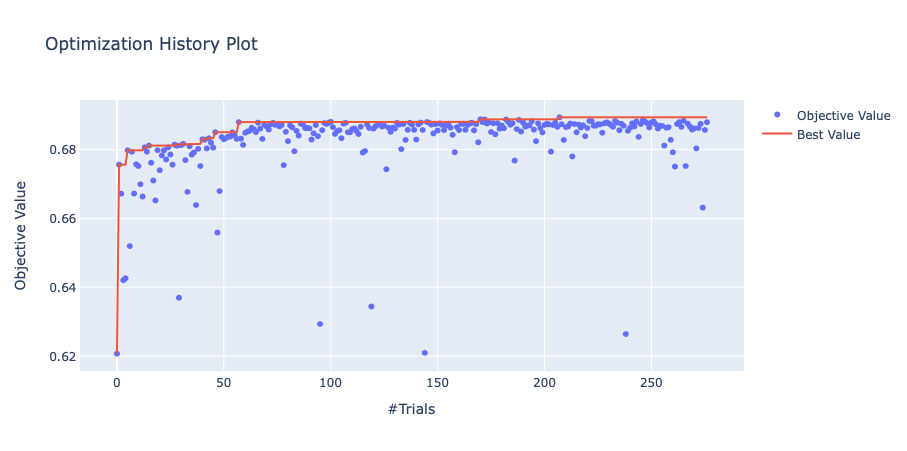

In [61]:
plot_optimization_history(study1)

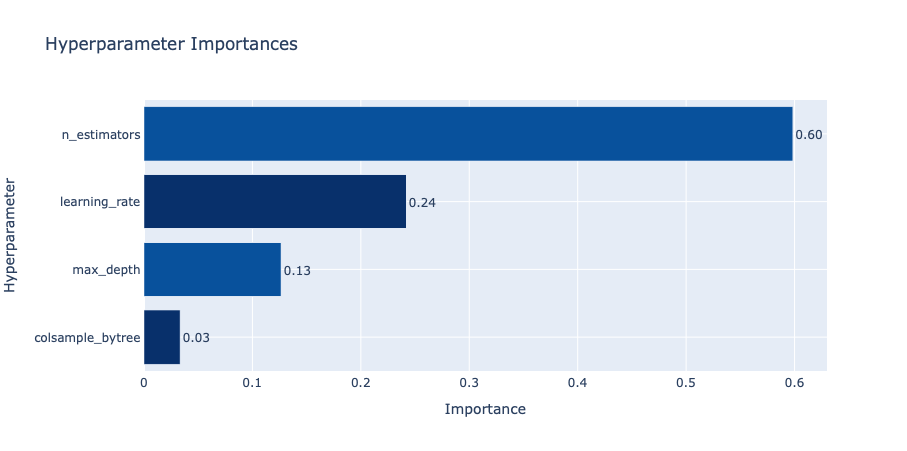

In [62]:
plot_param_importances(study1)

In [29]:
from sklearn.metrics import classification_report
target_names = ['HOME','SNF','Other','Dead/Expired']

In [91]:
train_pred1 = clf_op.predict(X_train)
test_pred1 = clf_op.predict(X_test)

In [92]:
print('Training')
print(classification_report(y_train, train_pred1, target_names=target_names))

Training
              precision    recall  f1-score   support

        HOME       0.84      0.98      0.90     21858
         SNF       0.82      0.64      0.72      4437
      Others       0.87      0.61      0.72      7407
        Dead       0.98      0.81      0.89      3514

    accuracy                           0.85     37216
   macro avg       0.88      0.76      0.81     37216
weighted avg       0.85      0.85      0.84     37216



In [66]:
print('Testing')
print(classification_report(y_test, test_pred, target_names=target_names))

              precision    recall  f1-score   support

        HOME       0.75      0.92      0.83      5464
         SNF       0.47      0.34      0.39      1109
      Others       0.52      0.33      0.40      1852
        Dead       0.62      0.44      0.51       879

    accuracy                           0.69      9304
   macro avg       0.59      0.51      0.53      9304
weighted avg       0.66      0.69      0.66      9304



### Control Overfitting by Gamma

In [16]:
class Objective(object):
    '''
    Four hyperparameters are tuned in this function: learning rate, number of rounds, 
    proportion of samples for each weak learner, and minimum loss reduction for each split.
    
    Examples
    --------
    >>> objective = Objective(X_train, y_train)
    >>> study = optuna.create_study(direction='maximize')
    >>> study.optimize(objective1, n_trials=100)
    '''
    
    
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __call__(self, trial):
        X, y = self.X, self.y
        
        learning_rate = trial.suggest_float('learning_rate', 0.01,0.5)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.2, 1)
        n_estimators = trial.suggest_int('n_estimators', 2, 1000, log=True)
        gamma = trial.suggest_float('gamma', 0.00001, 10, log=True)
        
        #apply early stopping
        clf = xgb.XGBClassifier(
            objective='multi:softmax',
            learning_rate=learning_rate,
            n_estimators = n_estimators,
            gamma = gamma,
            colsample_bytree = colsample_bytree,
            #sub_sample = sub_sample,
            random_state = 123 
        )


        score = cross_val_score(clf, X, y, n_jobs=-1,  cv=5).mean()
        return score

In [17]:
optuna.logging.set_verbosity(0)

In [18]:
%%time

objective1 = Objective(X_train, y_train)
study1 = optuna.create_study(direction='maximize')
study1.optimize(objective1, n_trials=100)

CPU times: user 5.3 s, sys: 2.29 s, total: 7.59 s
Wall time: 3h 8min 23s


In [19]:
study1.best_params

{'learning_rate': 0.04372790493554727,
 'colsample_bytree': 0.266798290436423,
 'n_estimators': 887,
 'gamma': 3.2261552797199973}

In [20]:
study1.best_value

0.6877684841478021

In [21]:
clf_op = xgb.XGBClassifier(**study1.best_params)
clf_op.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.266798290436423,
              gamma=3.2261552797199973, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.04372790493554727,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=887, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [22]:
clf_op.score(X_test, y_test)

0.6847592433361995

In [23]:
train_pred1 = clf_op.predict(X_train)
test_pred1 = clf_op.predict(X_test)

In [30]:
print('Training')
print(classification_report(y_train, train_pred1, target_names=target_names))

Training
              precision    recall  f1-score   support

        HOME       0.79      0.95      0.86     21858
         SNF       0.64      0.48      0.55      4437
       Other       0.72      0.46      0.56      7407
Dead/Expired       0.85      0.66      0.74      3514

    accuracy                           0.77     37216
   macro avg       0.75      0.64      0.68     37216
weighted avg       0.76      0.77      0.75     37216



In [31]:
print('Testing')
print(classification_report(y_test, test_pred1, target_names=target_names))

Testing
              precision    recall  f1-score   support

        HOME       0.75      0.92      0.82      5464
         SNF       0.45      0.34      0.39      1109
       Other       0.52      0.32      0.40      1852
Dead/Expired       0.61      0.44      0.51       879

    accuracy                           0.68      9304
   macro avg       0.58      0.50      0.53      9304
weighted avg       0.65      0.68      0.66      9304



### Save Model
- Compared to controlling overfitting by max depth, gamma could control overfitting better in this situation. 

In [32]:
import pickle
pickle_file = f'gbm_gamma.pickle'
with open(pickle_file, 'wb') as f:
    pickle.dump(clf_op, f)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

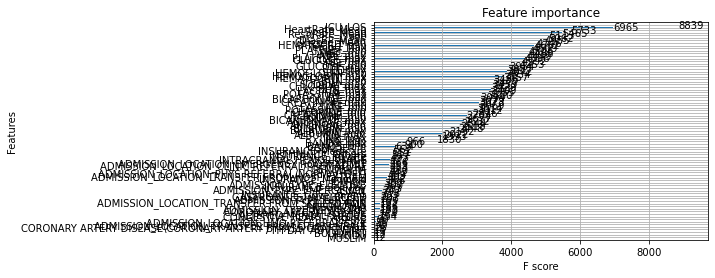

In [94]:
xgb.plot_importance(clf_op)

### Adaptive Boosting
- Here, we use AdaBoostClassifier from the sklearn package to perform adaptive boosting.
- We still focus on three hyperparameters
    - learning rate
    - number of trees
    - maximum depth of the base learners

In [69]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [78]:
class Objective2(object):
    '''
    Three hyperparameters are tuned in this function: learning rate, number of rounds, 
    proportion of samples for each weak learner, and maximum depth for each weak learner.
    
    Examples
    --------
    >>> objective = Objective(X_train, y_train)
    >>> study = optuna.create_study(direction='maximize')
    >>> study.optimize(objective1, n_trials=100)
    '''
    
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __call__(self, trial):
        X, y = self.X, self.y
        
        learning_rate = trial.suggest_float('learning_rate', 0.01,2)
        n_estimators = trial.suggest_int('n_estimators', 2, 1000, log=True)
        max_depth = trial.suggest_int('max_depth', 1, 10)
        base_estimator = DecisionTreeClassifier(max_depth=max_depth)
        
        clf = AdaBoostClassifier(base_estimator = base_estimator,
                                 n_estimators=n_estimators,
                                 learning_rate = learning_rate,
                                 random_state=123)


        score = cross_val_score(clf, X, y, n_jobs=-1,  cv=5).mean()
        return score

In [79]:
%%time

objective2 = Objective2(X_train, y_train)
study2 = optuna.create_study(direction='maximize')
study2.optimize(objective2, n_trials=100)

CPU times: user 4.72 s, sys: 2.13 s, total: 6.85 s
Wall time: 33min 3s


In [80]:
df_results2 = study2.trials_dataframe()
df_results2

,number,value,datetime_start,datetime_complete,duration,params_learning_rate,params_max_depth,params_n_estimators,state
0,0,0.551160,2020-11-05 14:06:38.667036,2020-11-05 14:07:14.382234,0 days 00:00:35.715198,1.555868,5,89,COMPLETE
1,1,0.626317,2020-11-05 14:07:14.382306,2020-11-05 14:07:56.616596,0 days 00:00:42.234290,0.181692,7,76,COMPLETE
2,2,0.612317,2020-11-05 14:07:56.616649,2020-11-05 14:07:57.471410,0 days 00:00:00.854761,1.472060,1,7,COMPLETE
3,3,0.591788,2020-11-05 14:07:57.471460,2020-11-05 14:08:22.877969,0 days 00:00:25.406509,1.947817,2,155,COMPLETE
4,4,0.493282,2020-11-05 14:08:22.878015,2020-11-05 14:08:40.638139,0 days 00:00:17.760124,1.954716,7,33,COMPLETE
...,...,...,...,...,...,...,...,...,...
95,95,0.660656,2020-11-05 14:37:24.784937,2020-11-05 14:37:49.294020,0 days 00:00:24.509083,0.056540,2,149,COMPLETE
96,96,0.587409,2020-11-05 14:37:49.294110,2020-11-05 14:38:04.272386,0 days 00:00:14.978276,0.011380,1,158,COMPLETE
97,97,0.578433,2020-11-05 14:38:04.272480,2020-11-05 14:38:23.212439,0 days 00:00:18.939959,1.880016,2,115,COMPLETE
98,98,0.658803,2020-11-05 14:38:23.212555,2020-11-05 14:39:34.533893,0 days 00:01:11.321338,0.052295,4,231,COMPLETE


In [83]:
params = study2.best_params

In [84]:
clf_op2 = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=params['max_depth']),
                                 n_estimators=params['n_estimators'],
                                 learning_rate = params['learning_rate'],
                                 random_state=123)
clf_op2.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.12536732796092792, n_estimators=116,
                   random_state=123)

In [85]:
clf_op2.score(X_test, y_test)

0.6615434221840069

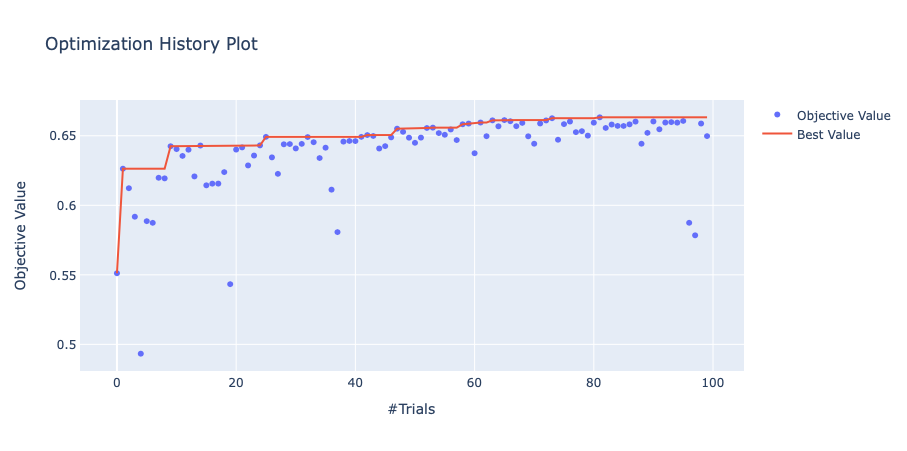

In [86]:
plot_optimization_history(study2)

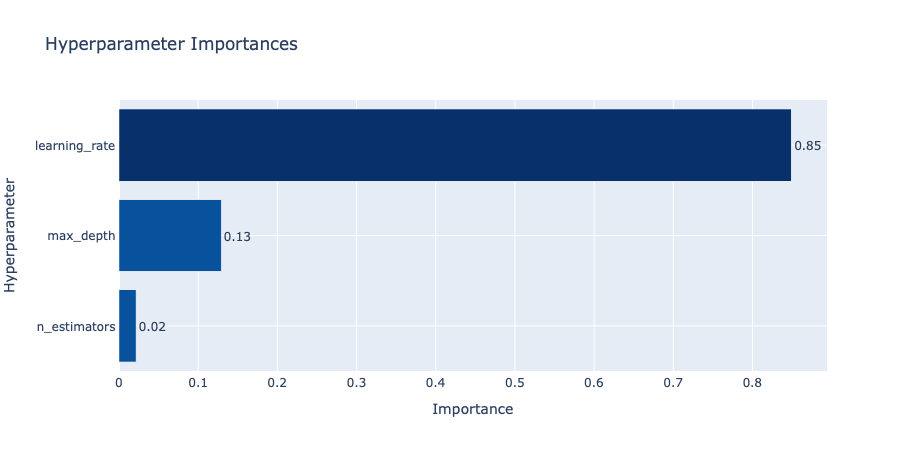

In [87]:
plot_param_importances(study2)

In [88]:
train_pred = clf_op2.predict(X_train)
test_pred = clf_op2.predict(X_test)

In [89]:
print('Training')
print(classification_report(y_train, train_pred, target_names=target_names))

Training
              precision    recall  f1-score   support

        HOME       0.73      0.90      0.81     21858
         SNF       0.46      0.34      0.39      4437
      Others       0.47      0.29      0.35      7407
        Dead       0.67      0.43      0.52      3514

    accuracy                           0.67     37216
   macro avg       0.58      0.49      0.52     37216
weighted avg       0.64      0.67      0.64     37216



In [90]:
print('Testing')
print(classification_report(y_test, test_pred, target_names=target_names))

Testing
              precision    recall  f1-score   support

        HOME       0.73      0.90      0.81      5464
         SNF       0.44      0.34      0.38      1109
      Others       0.45      0.29      0.35      1852
        Dead       0.62      0.35      0.45       879

    accuracy                           0.66      9304
   macro avg       0.56      0.47      0.50      9304
weighted avg       0.63      0.66      0.63      9304



### Conclusion
- Among all these boosting models, gradient boosting controlled by gamma performs best with training accuracy = 0.77 and testing accuracy = 0.68.